In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pywt
import pandas as pd
import scipy.stats as stats

from scipy.io import loadmat

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

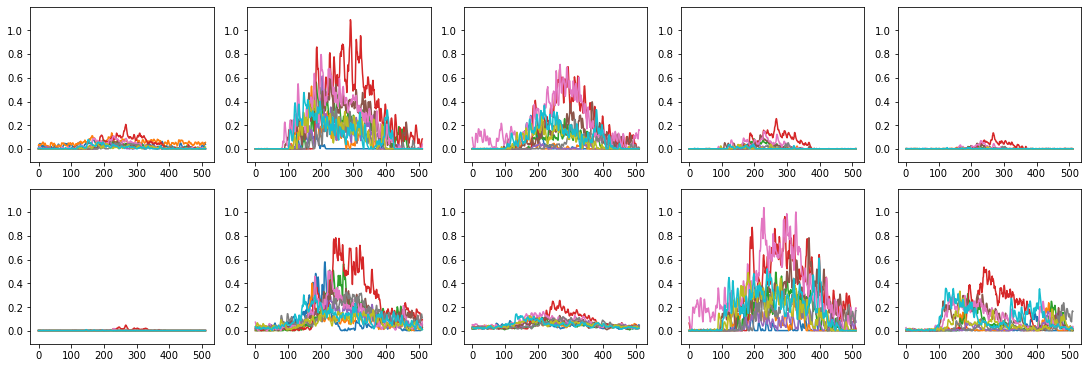

In [3]:
data = loadmat("E:\\nx-421\\data\\dataset_1\\S1_A1_E1.mat")
data

emg_data = data["emg"]
stimulus = data["stimulus"]
repetition = data["repetition"]

n_channels = emg_data.shape[1]

n_stimuli = int(np.unique(stimulus).size - 1)  # remove rest
n_repetitions = int(np.unique(repetition).size - 1)  # remove rest

n_epochs = n_stimuli * n_repetitions
n_tsteps = 512  # see last exercise session :D

emg_tensor = np.zeros((n_stimuli, n_repetitions, n_tsteps, n_channels))
for i in range(n_stimuli):
    for j in range(n_repetitions):
        sel = np.squeeze(np.logical_and(stimulus == (i + 1), repetition == (j + 1)))
        emg_selected_data = emg_data[sel, :]
        emg_tensor[i, j, :, :] = emg_selected_data[:n_tsteps, :]
        
# just to check that I copy-pasted correctly
fig, ax = plt.subplots(2, 5, figsize=(15, 5), constrained_layout=True)
ax = ax.ravel()
data_max = np.max(emg_tensor[0, :, :, :])
data_range = data_max
for j in range(n_channels):
    for k in range(n_repetitions):
        ax[j].plot(emg_tensor[0, k, :, j])
    ax[j].set_ylim([0 - data_range / 10, data_max + data_range / 10])

In [4]:
# Example of features
def features_estimation(signal, fs):
    """
    Compute time, frequency and time-frequency features from signal.
    :param signal: numpy array signal.
    :param channel_name: string variable with the EMG channel name in analysis.
    :param fs: int variable with the sampling frequency used to acquire the signal
    :return: total_feature_matrix -- python list
    :return: features_names -- python list with
    """

    features_names = ['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC', 'DASDV', 'ZC', 'WAMP', 'MYOP', "MNP", "TP",
                      "MNF", "MDF", "PKF", "WENT"]

    time_matrix = time_features_estimation(signal)
    frequency_matrix = frequency_features_estimation(signal, fs)
    time_frequency_matrix = time_frequency_features_estimation(signal)
    total_feature_matrix = np.column_stack((time_matrix, frequency_matrix, time_frequency_matrix))

    return total_feature_matrix


def time_features_estimation(signal):
    """
    Compute time features from signal
    :param signal: numpy array signal.
    """

    th = np.mean(signal) + 3 * np.std(signal)

    variance = (np.var(signal))
    rms = (np.sqrt(np.mean(signal ** 2)))
    iemg = (np.sum(abs(signal)))  # Integral
    mav = (np.sum(np.absolute(signal)) / len(signal))  # Mean Absolute Value
    log_detector = (np.exp(np.sum(np.log10(np.absolute(signal))) / len(signal)))
    wl = (np.sum(abs(np.diff(signal))))  # Wavelength
    aac = (np.sum(abs(np.diff(signal))) / len(signal))  # Average Amplitude Change
    dasdv = (math.sqrt((1 / (len(signal) - 1)) * np.sum((np.diff(signal)) ** 2)))  # Difference absolute standard deviation value
    zc = (zcruce(signal, th))  # Zero-Crossing
    wamp = (wilson_amplitude(signal, th))  # Willison amplitude
    myop = (myopulse(signal, th))  # Myopulse percentage rate

    time_features_matrix = np.column_stack((variance, rms, iemg, mav, log_detector, wl, aac, dasdv, zc, wamp, myop))
    return time_features_matrix


def frequency_features_estimation(signal, fs):
    """
    Compute frequency features from signal
    :param signal: numpy array signal.
    :param fs: sampling frequency of the signal.
    :return: frequency_features_matrix: narray matrix with the frequency features stacked by columns.
    """

    frequency, power = spectrum(signal, fs)
    
    mnp = (np.sum(power) / len(power))  # Mean power
    tot = (np.sum(power))  # Total power
    mnf = (mean_freq(frequency, power))  # Mean frequency
    mdf = (median_freq(frequency, power))  # Median frequency
    pkf = (frequency[power.argmax()])  # Peak frequency

    frequency_features_matrix = np.column_stack((mnp, tot, mnf, mdf, pkf))

    return frequency_features_matrix


def time_frequency_features_estimation(signal):
    """
    Compute time-frequency features from signal
    :param signal: numpy array signal.
    :return: h_wavelet: list
    """
    h_wavelet = []

    E_a, E = wavelet_energy(signal, 'db2', 4)
    E.insert(0, E_a)
    E = np.asarray(E) / 100

    h_wavelet.append(-np.sum(E * np.log2(E)))

    return h_wavelet


def wilson_amplitude(signal, th):
    x = abs(np.diff(signal))
    umbral = x >= th
    return np.sum(umbral)


def myopulse(signal, th):
    umbral = signal >= th
    return np.sum(umbral) / len(signal)


def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)

    return fh, power

def shannon(x):
    N = len(x)
    nb = 19
    hist, bin_edges = np.histogram(x, bins=nb)
    counts = hist / N
    nz = np.nonzero(counts)

    return np.sum(counts[nz] * np.log(counts[nz]) / np.log(2))


def zcruce(X, th):
    th = 0
    cruce = 0
    for cont in range(len(X) - 1):
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce


def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]


def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    arr, _ = pywt.coeffs_to_array(coeffs)
    Et = np.sum(arr ** 2)
    cA = coeffs[0]
    Ea = 100 * np.sum(cA ** 2) / Et
    Ed = []

    for k in range(1, len(coeffs)):
        cD = list(coeffs[k].values())
        cD = np.asarray(cD)
        Ed.append(100 * np.sum(cD ** 2) / Et)

    return Ea, Ed


def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def med_freq(f, P):
    Ptot = np.sum(P) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += P[i]
        errel = (Ptot - temp) / Ptot
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return f[i]

In [5]:
fs = 100
out = features_estimation(signal=emg_tensor[0, 0, :, 1], fs=100)
out.shape

(1, 17)

In [10]:
all_feature_list = []
labels = []
for i in range(n_stimuli):
    for j in range(n_repetitions):
        channelwise_feature_list = []
        for k in range(n_channels):
            current_channel_features = features_estimation(signal=emg_tensor[i, j, :, k], fs=fs)
            channelwise_feature_list.append(current_channel_features)
        channelwise_features = np.hstack(channelwise_feature_list)
        all_feature_list.append(channelwise_features)
        labels.append(i)

emg_features = np.vstack(all_feature_list)
labels = np.array(labels)

emg_features.shape

c:\users\romeni\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


(120, 170)

In [17]:
feature_names = [
    "VAR", "RMS", "IEMG", "MAV", "LOG", 
    "WL", "ACC", "DASDV", "ZC", "WAMP", 
    "MYOP", "MNP", "TP", "MNF", "MDF",
    "PKF", "WENT"
]
n_features_per_channel = len(feature_names)

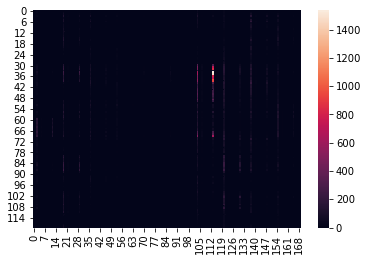

In [18]:
# check for meaningless features
fig, ax = plt.subplots()
sns.heatmap(data=emg_features, ax=ax)

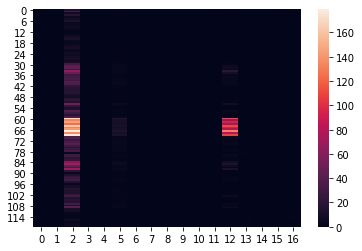

In [19]:
fig, ax = plt.subplots()
sns.heatmap(data=emg_features[:, :n_features_per_channel], ax=ax)

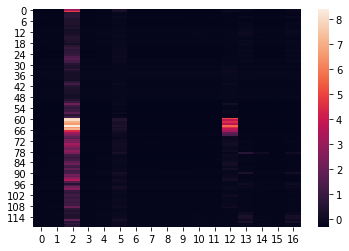

In [20]:
from scipy.stats import zscore

emg_zscores = zscore(emg_features, axis=1)

fig, ax = plt.subplots()
sns.heatmap(data=emg_zscores[:, :n_features_per_channel], ax=ax)

c:\users\romeni\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


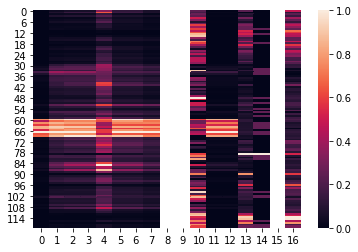

In [27]:
emg_mins = np.expand_dims(np.min(emg_features, axis=0), axis=0)
emg_maxs = np.expand_dims(np.max(emg_features, axis=0), axis=0)
emg_mins = np.tile(emg_mins, [120, 1])
emg_maxs = np.tile(emg_maxs, [120, 1])

emg_minmax = (emg_features - emg_mins) / (emg_maxs - emg_mins)
fig, ax = plt.subplots()
sns.heatmap(emg_minmax[:, :n_features_per_channel], ax=ax)

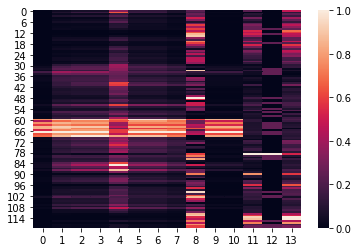

In [31]:
# feature 8, 9, 15 are meaningless for these data
multiples_1 = np.arange(start=8, stop=170, step=17)
multiples_2 = np.arange(start=9, stop=170, step=17)
multiples_3 = np.arange(start=15, stop=170, step=17)
bad_cols = np.hstack((multiples_1, multiples_2, multiples_3))
emg_features_ok = np.delete(emg_features, bad_cols, 1)

emg_mins = np.expand_dims(np.min(emg_features_ok, axis=0), axis=0)
emg_maxs = np.expand_dims(np.max(emg_features_ok, axis=0), axis=0)
emg_mins = np.tile(emg_mins, [120, 1])
emg_maxs = np.tile(emg_maxs, [120, 1])

emg_minmax = (emg_features_ok - emg_mins) / (emg_maxs - emg_mins)
fig, ax = plt.subplots()
sns.heatmap(emg_minmax[:, :(n_features_per_channel - 3)], ax=ax)

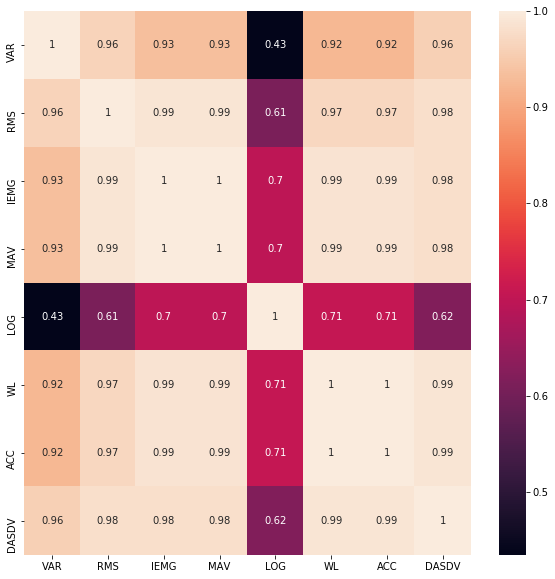

In [34]:
n_features_per_channel = n_features_per_channel - 3
# select only features for one channel to see cross-correlations
feature_crosscorr = np.corrcoef(emg_features_ok[:, :n_features_per_channel].T)
feature_crosscorr.shape

feature_names = [
    "VAR", "RMS", "IEMG", "MAV", "LOG", "WL", 
    "ACC", "DASDV", "MYOP", "MNP", "TP", 
    "MNF", "MDF", "WENT"
]
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=feature_crosscorr, ax=ax, annot=True)
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names);

[]

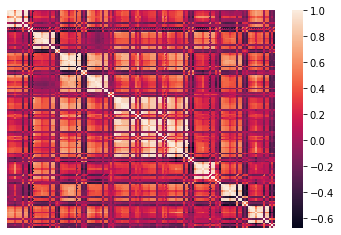

In [36]:
feature_names = [
    "VAR", "RMS", "IEMG", "MAV", "LOG", "WL", 
    "ACC", "DASDV", "ZC", "WAMP", 'MYOP', "MNP", 
    "TP", "MNF", "MDF", "PKF", "WENT"
]

all_feature_crosscorr = np.corrcoef(emg_features_ok.T)
fig, ax = plt.subplots()
sns.heatmap(data=all_feature_crosscorr, ax=ax)
ax.set_xticks([])
ax.set_yticks([])

In [38]:
emg_features_norm = zscore(emg_features_ok, axis=1)

Text(0, 0.5, 'Residual variance')

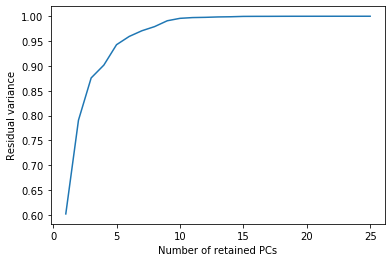

In [39]:
pca = PCA(n_components=25)
features_pca = pca.fit(emg_features_norm).transform(emg_features_norm)
residual_variance = 1 - pca.explained_variance_ratio_
fig, ax = plt.subplots()
ax.plot(np.arange(1, 26), residual_variance)
ax.set_xlabel("Number of retained PCs")
ax.set_ylabel("Residual variance")

(96, 140)


(-0.1, 1.1)

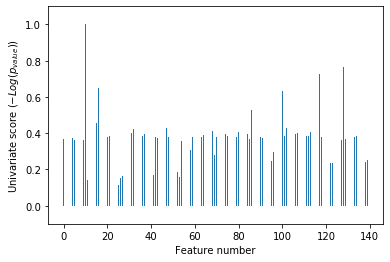

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(emg_features_norm, labels, test_size=0.2)
selector = SelectKBest(f_classif)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

X_indices = np.arange(emg_features_norm.shape[-1])
fig, ax = plt.subplots()
ax.bar(X_indices, scores, width=0.2)
ax.set_xlabel("Feature number")
ax.set_ylabel(r"Univariate score ($-Log(p_{value})$)")
ax.set_ylim([-0.1, 1.1])

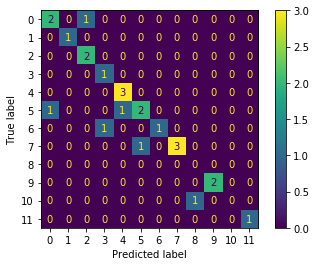

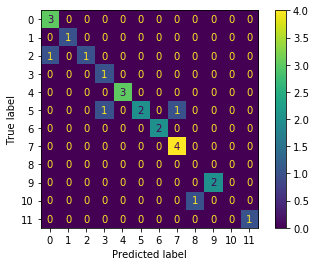

In [48]:
sel = np.argwhere(scores > 0.5).reshape(1, len(np.argwhere(scores > 0.5)))
X_train_sel = X_train[:, sel[0]]
X_test_sel = X_test[:, sel[0]]

# define model
model_noSelection = LinearDiscriminantAnalysis()
# fit model
model_noSelection.fit(X_train, y_train)
y_pred = model_noSelection.predict(X_test)

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

# define model
model_Selection = LinearDiscriminantAnalysis()
# fit model
model_Selection.fit(X_train_sel, y_train)
y_pred = model_Selection.predict(X_test_sel)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

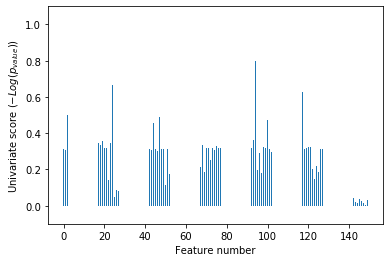

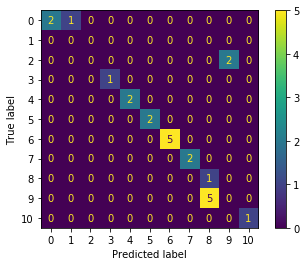

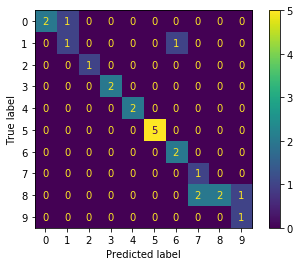

In [55]:
emg_features_with_garbage = np.hstack((emg_features_norm, zscore(np.random.rand(120, 10))))
X_train, X_test, y_train, y_test = train_test_split(emg_features_with_garbage, labels, test_size=0.2)

selector = SelectKBest(f_classif)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

sel = np.argwhere(scores > 0.5).reshape(1, len(np.argwhere(scores > 0.5)))
X_train_sel = X_train[:, sel[0]]
X_test_sel = X_test[:, sel[0]]

X_indices = np.arange(emg_features_norm.shape[-1] + 10)
fig, ax = plt.subplots()
ax.bar(X_indices, scores, width=0.2)
ax.set_xlabel("Feature number")
ax.set_ylabel(r"Univariate score ($-Log(p_{value})$)")
ax.set_ylim([-0.1, 1.1])

model_noSelection = LinearDiscriminantAnalysis()
# fit model
model_noSelection.fit(X_train, y_train)
y_pred = model_noSelection.predict(X_test)

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

# define model
model_Selection = LinearDiscriminantAnalysis()
# fit model
model_Selection.fit(X_train_sel, y_train)
y_pred = model_Selection.predict(X_test_sel)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

Text(0, 0.5, 'Repetition [1]')

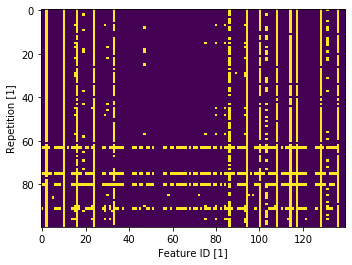

In [60]:
sel = np.zeros((100, 140))
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(emg_features_norm, labels, test_size=0.2)
    selector = SelectKBest(f_classif)
    selector.fit(X_train, y_train)
    scores = -np.log10(selector.pvalues_)
    scores /= scores.max()

    sel[i, :] = scores > 0.5

fig, ax = plt.subplots()
ax.imshow(sel)
ax.set_xlabel("Feature ID [1]")
ax.set_ylabel("Repetition [1]")